In [2]:
import gzip
import sys
import os
import binascii
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [3]:
EC = "../data/EC_OHLC_30.csv.gz"
ES = "../data/ES_OHLC_30.csv.gz"
FV = "../data/FV_OHLC_30.csv.gz"
NQ = "../data/NQ_OHLC_30.csv.gz"
TY = "../data/TY_OHLC_30.csv.gz"
UB = "../data/UB_OHLC_30.csv.gz"
US = "../data/US_OHLC_30.csv.gz"
ann = '../data/announcements-dailyfx.csv'

In [4]:
class OHLC:

    def __init__(self, ts0, O, H, L, C, T, V, ts=None):
        self.ts0, self.O, self.H, self.L, self.C, self.T, self.V, self.ts = ts0, O, H, L, C, T, V, ts
        if self.ts is None : self.ts = self.ts0

    def __str__(self):
        return ("%s,%10.6f,%10.6f,%10.6f,%10.6f,%6d,%6d") % (str(self.ts0),self.O, self.H, self.L, self.C, self.T, int(self.V))

In [5]:
class Utils:

    def DT(year, month, day, hour, minute, second):
        return dt.datetime(year, month, day, hour, minute, second, 0)

    def getDT(d, t, micros=False):
        if "/" in d:
            dv = d.split("/")
            year, month, day = int(dv[2]), int(dv[0]), int(dv[1])
        else:
            dv = d.split("-")
            year, month, day = int(dv[0]), int(dv[1]), int(dv[2])
        tv =  t.split(":")
        try:
            h, m, s = int(tv[0]), int(tv[1]), int(tv[2].split(".")[0])
            us = 0 if micros == False else int(tv[2].split(".")[-1])*1000
        except:
            print("Error parsing datetime time=%s, date=%s" % (t, d))
            return dt.datetime(2018,1,1)
        return dt.datetime(year, month, day, h,m,s,us)

    def parse(line):
        # trades data : date, time, price, qty, flag -> datetime, price , qty
        if type(line) != str: line = line.decode("ascii")
        dv = line.strip().split(",")
        return OHLC(Utils.getDT(dv[0].split(" ")[0],dv[0].split(" ")[1]),
                    float(dv[1]), float(dv[2]), float(dv[3]),float(dv[4]),int(dv[5]),float(dv[6]))

In [6]:
def read_file(infile):
    records=[]
    with gzip.open(infile) as rdr:
        for line in rdr:
            records.append(Utils.parse(line))
    return records

In [7]:
def sortByMax(hist):
    return sorted(hist, key = lambda x : x.H - x.L, reverse=True)


In [8]:
def getRecords(hist, start, end):
    rec = []
    for h in hist:
        if h.ts > end :
            break
        if h.ts >= start :
            rec.append(h)
    return rec


In [9]:
def get_ancmt(ancmt, start, end):
    rec = []
    for a in ancmt:
        if a[0] >= start and a[0] < end :
            rec.append(a)
    return rec

In [16]:
def parse_Ancmt(src):
    arr = []
    with open(src, 'r') as f:
        for line in f:
            line = line.rstrip().replace('"', '').split(',')
            if line[1] == "usd" and line[3] == "High":
                date_time = line[0].split('T')
                yy,mm,dd = date_time[0].split('-')
                h,m,s = date_time[1].split(':')
                line[0] = dt.datetime(int(yy),int(mm),int(dd),int(h),int(m),int(s)) + dt.timedelta(hours=1)
                arr.append(line)
    return arr
                

In [11]:
def parse_sort(file, num):
    hist = read_file(file)
    records = sortByMax(hist)
    top_array = []
    for i in range(num):
        line = str(records[i]).split(',')
        date_time = line[0].split(' ')
        yy,mm,dd = date_time[0].split('-')
        h,m,s = date_time[1].split(':')
        line[0] = dt.datetime(int(yy),int(mm),int(dd),int(h),int(m),int(s))
        for j in range(1,7):
            line[j] = float(line[j])
        line.append(round(line[2]-line[3],6))
        line.append(round(line[1]-line[4],6))
        top_array.append(line)
    return top_array, hist



In [12]:
def get_date_range(array):
    date_list = [array[i][0] for i in range(len(array))]
    return min(date_list), max(date_list), date_list

In [13]:
def ohlc_to_string(data):
    arr = []
    for i in range(len(data)):
        line = str(data[i]).split(',')
        date_time = line[0].split(' ')
        yy,mm,dd = date_time[0].split('-')
        h,m,s = date_time[1].split(':')
        line[0] = dt.datetime(int(yy),int(mm),int(dd),int(h),int(m),int(s))
        for j in range(1,7):
            line[j] = float(line[j])
        line.append(round(line[2]-line[3],6))
        line.append(round(line[1]-line[4],6))
        arr.append(line)
    return arr  

In [14]:
def main(filecode):
    top_array, hist = parse_sort(filecode, 5)
    start, end, top_date_list = get_date_range(top_array)
    start = start - dt.timedelta(days=2)
    recs = getRecords(hist, start, end)
    y = [r.O for r in recs]
    x = [i for i in range(len(recs))]
    
    recs = ohlc_to_string(recs)
    recs_ts = [r[0] for r in recs]
    x1_ts = [r[0] for r in top_array]
    x1 = []
    for ts in x1_ts:
        x1.append(recs_ts.index(ts))
    y1 = [ r[1] for r in top_array]
    
    all_ancmt = get_ancmt(parse_Ancmt(ann), start, end)
    x2_ts = [r[0] for r in all_ancmt]
    x2 = []
    for i, ts in enumerate(x2_ts):
        try:
            index = recs_ts.index(ts)
        except ValueError:
            pass
        else:
            x2.append(index)
    recs_O = [r[1] for r in recs]
    y2 = [recs_O[i] for i in x2]
    
    
    plt.figure(figsize=(20,10))
    plt.plot(x,y, alpha=.4)
    plt.scatter(x1,y1, color='r', s =100)
    plt.scatter(x2,y2, color='g', marker='^', s=70, alpha=.7)
    plt.show()

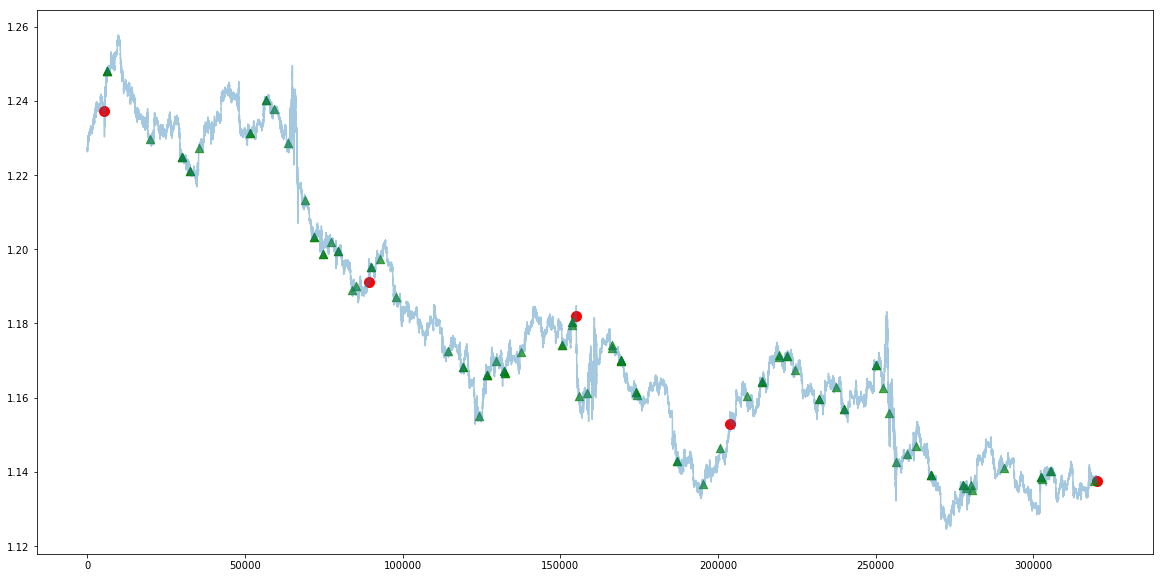

In [17]:
main(EC)

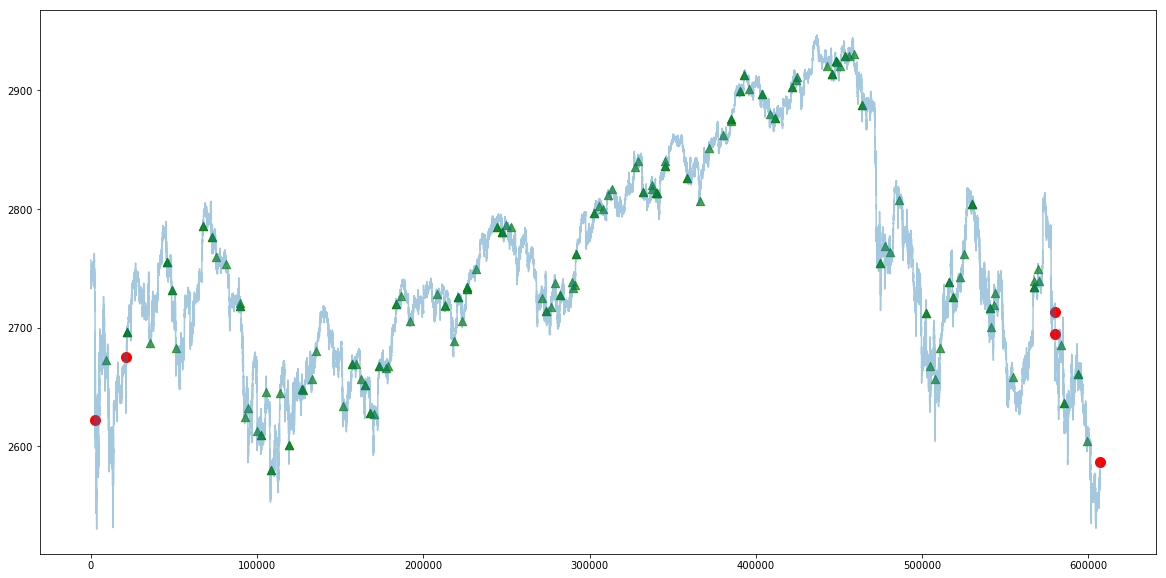

In [18]:
main(ES)

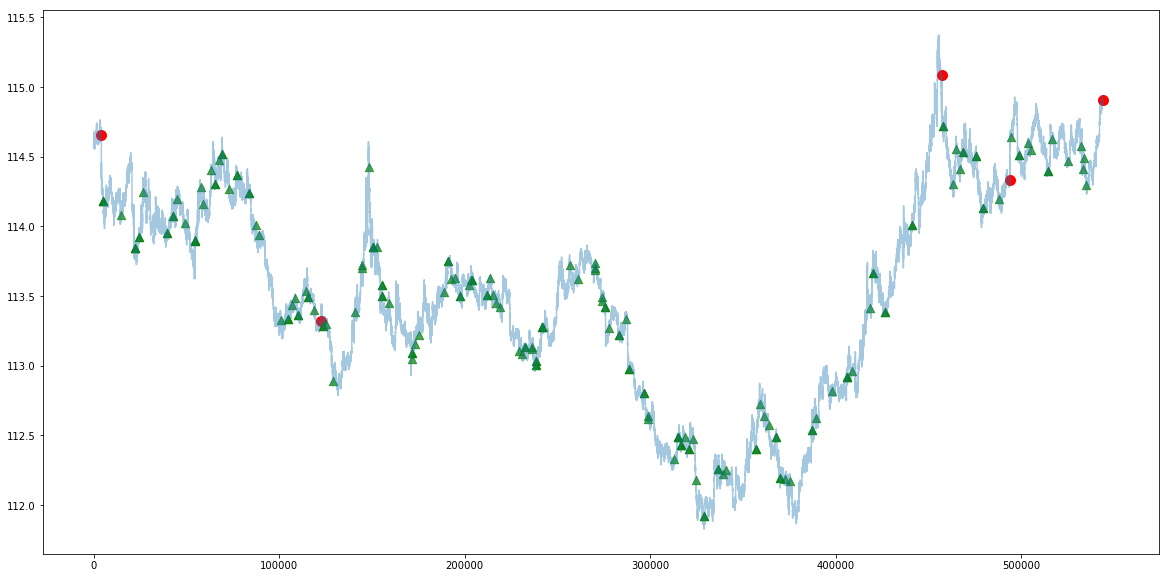

In [19]:
main(FV)

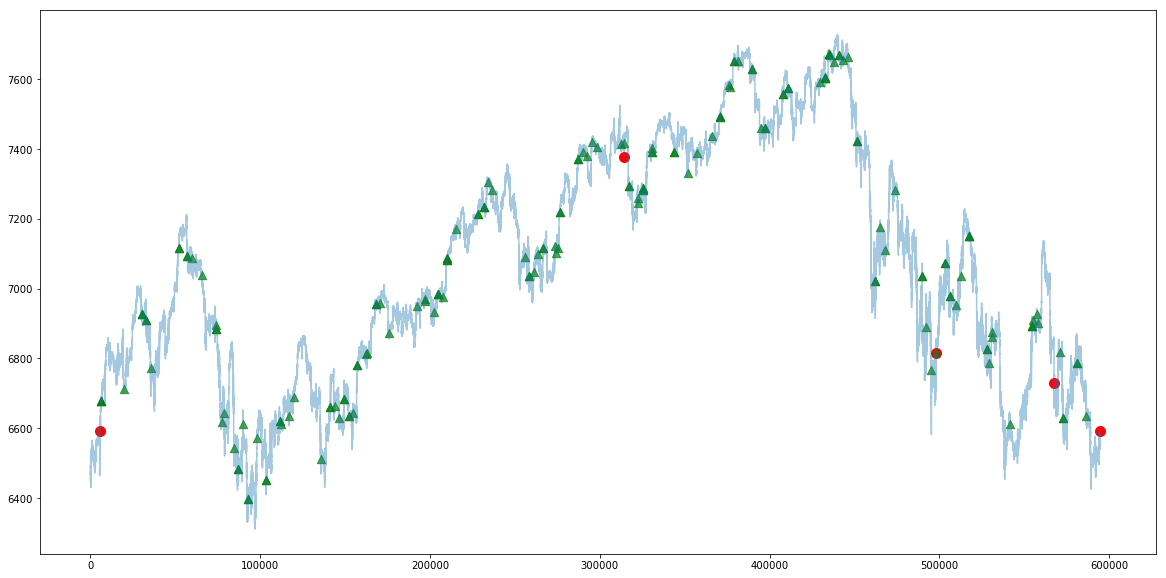

In [20]:
main(NQ)

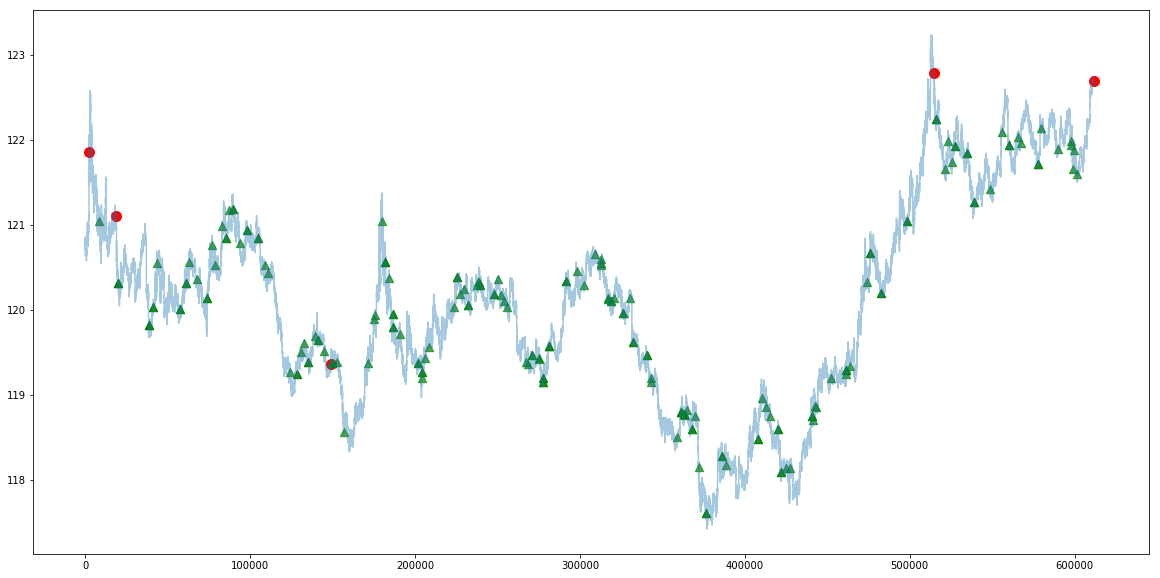

In [21]:
main(TY)

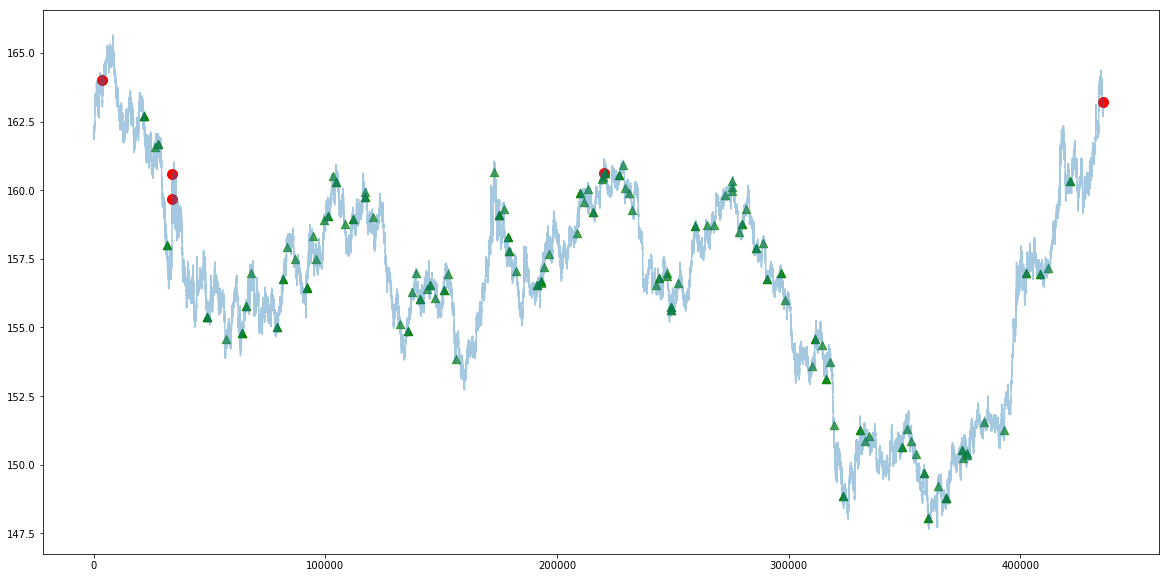

In [22]:
main(UB)

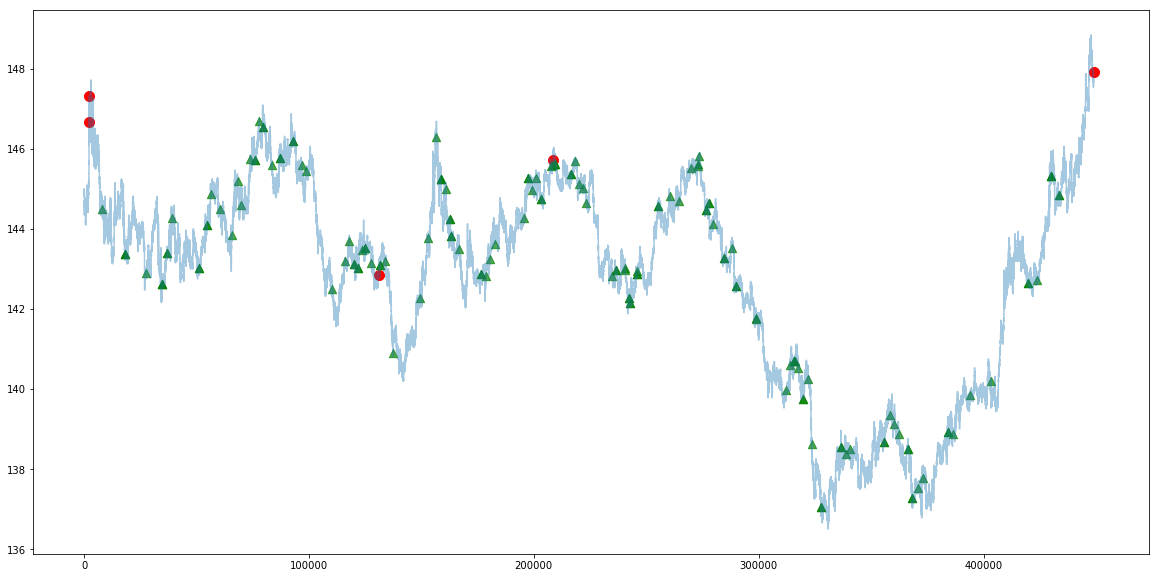

In [23]:
main(US)